# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

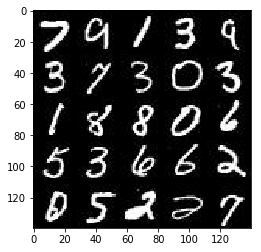

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

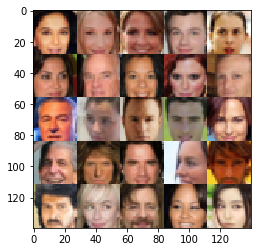

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [42]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_size = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_size), name='input_real')
    inputs_z =  tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='l_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2=  tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256 , 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
# def generator(z, out_channel_dim, is_train=True):
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # First fully generator layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    
    # Create our input placeholders
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # since we are using tanh output on the generator, 
                # images from the generator are scaled from -1 to +1, 
                # so we need to scale our images from a range of (-0.5, 0.5) to a range of (-1, +1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})

                if steps % 10 == 0:
                    # After each 100 batches, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g)) 
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5032... Generator Loss: 14.8821
Epoch 1/2... Discriminator Loss: 0.4014... Generator Loss: 7.2604
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 4.7578
Epoch 1/2... Discriminator Loss: 2.1969... Generator Loss: 0.3281
Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 3.0470
Epoch 1/2... Discriminator Loss: 2.2118... Generator Loss: 4.6855
Epoch 1/2... Discriminator Loss: 1.7774... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.8130


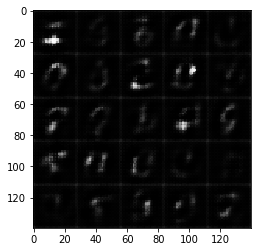

Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.2990
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.4749
Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 1.8308... Generator Loss: 0.3078


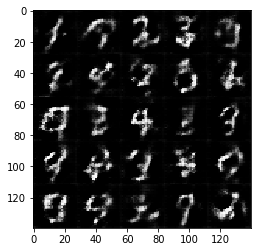

Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 2.1058... Generator Loss: 2.8169
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.5600
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.8036


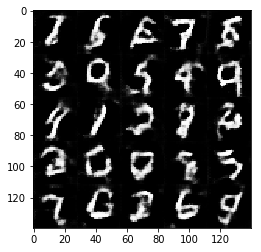

Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 1.5452
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 2.5334
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.9989
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.6553


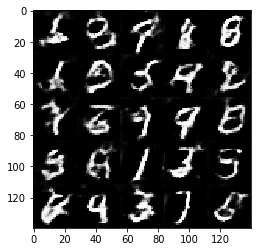

Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.5064
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.9222
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.4842... Generator Loss: 1.9780
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.8203


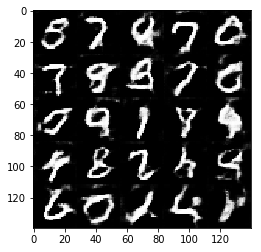

Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 1.1143
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 3.2627... Generator Loss: 3.8451
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 1.1256


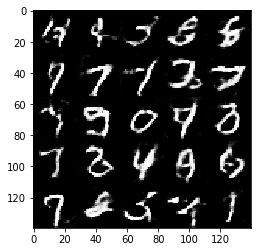

Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 1.2868
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 2.1055
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.9323


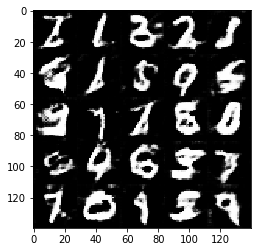

Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.2954
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.9270
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 1.3056
Epoch 1/2... Discriminator Loss: 2.0045... Generator Loss: 0.2777


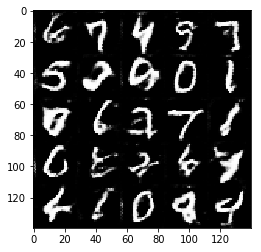

Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 1.0659
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.7278... Generator Loss: 0.3600
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.8450... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.6798
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.0034


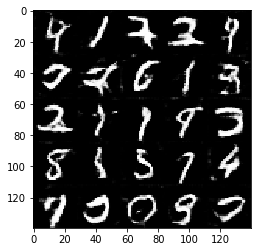

Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.0790
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.9084


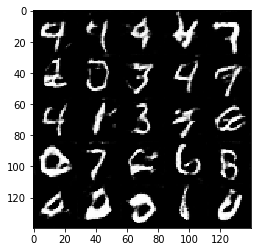

Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 1.0316
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.4960
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 1.5065... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.9157


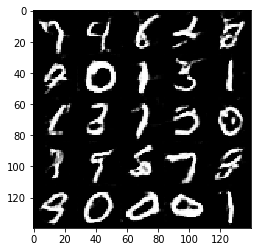

Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.0907... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.0604... Generator Loss: 1.0927
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.4624
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.9883
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.8415


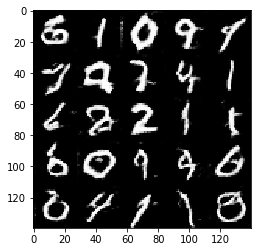

Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.4806
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.9940


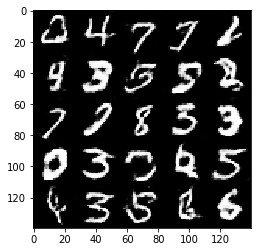

Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 1.3774
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 1.0043
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 1.2558
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 1.9339
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 1.0751
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 1.3309


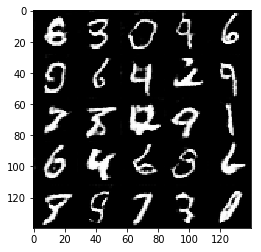

Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.5974
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 2.3699
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.5818
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 2.0205
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 2.2075


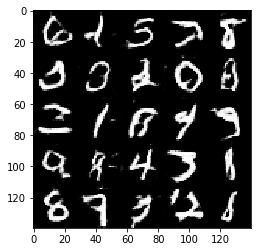

Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.4535
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 0.9449
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.5779
Epoch 2/2... Discriminator Loss: 1.5478... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 2.0095
Epoch 2/2... Discriminator Loss: 0.9145... Generator Loss: 1.1250


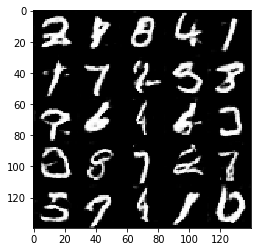

Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 1.5325
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.8146
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 2.1023
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.1529
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.5607
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 0.8437


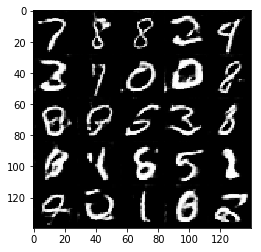

Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 2.0664
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 2.1453
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 2.9195
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.0098


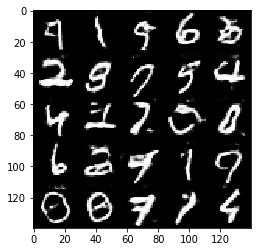

Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.5495
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 0.9819
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.0061
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 0.9755
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.1255


IndexError: list index out of range

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 18.7458
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 2.3305
Epoch 1/1... Discriminator Loss: 2.0089... Generator Loss: 5.5435
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 3.0463
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 2.5949... Generator Loss: 6.8988


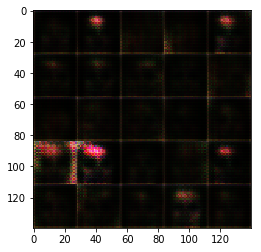

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.9000... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7014


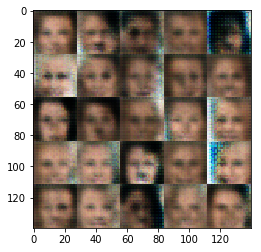

Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8802


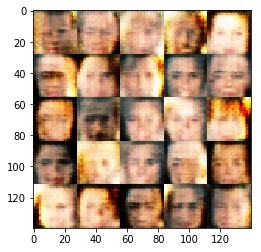

Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 2.2509
Epoch 1/1... Discriminator Loss: 1.8081... Generator Loss: 2.4490
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 2.3389... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6931


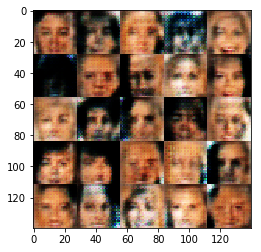

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7974


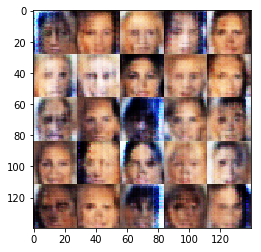

Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7685


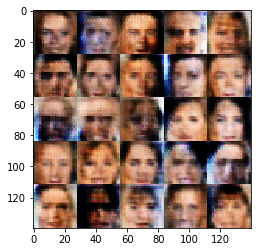

Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 2.0583


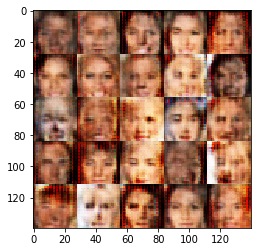

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 1.6697
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9980


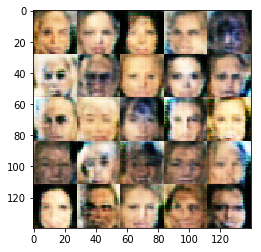

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 2.1662... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.4657


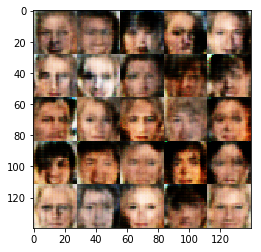

Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.8901


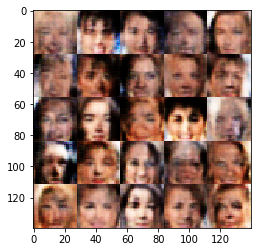

Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6320


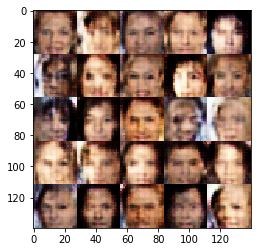

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 1.7853
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.9016


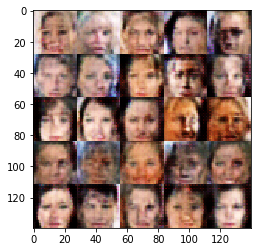

Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8140


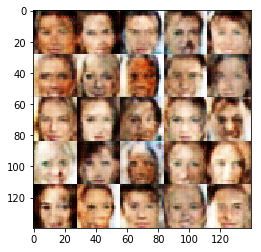

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6803


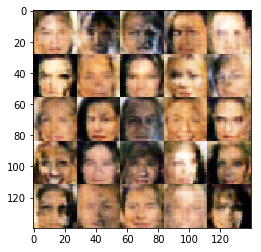

Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7411


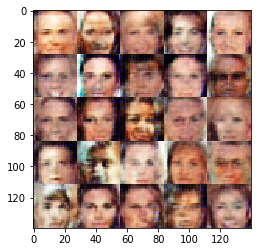

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 1.2043


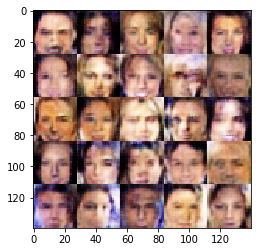

Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.0256


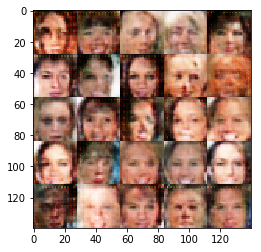

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.9458


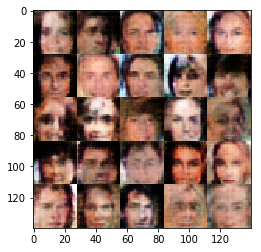

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 2.6619... Generator Loss: 2.9414
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.0484


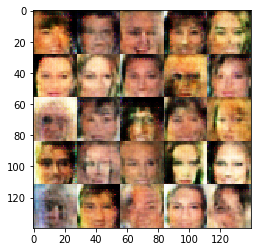

Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8777


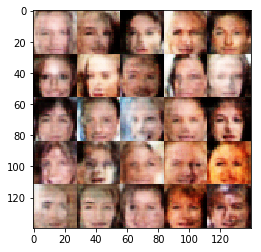

Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9420


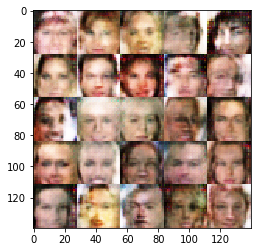

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 2.2776


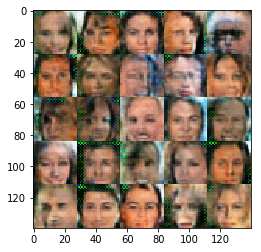

Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8776


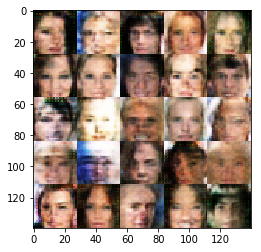

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.9204


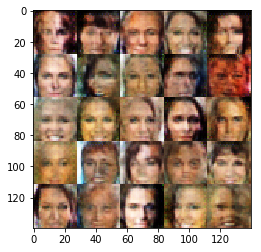

Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.1028


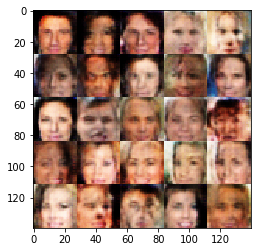

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5570


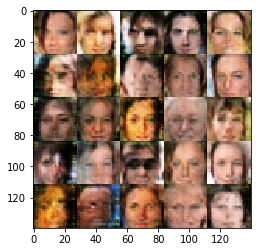

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 1.1599


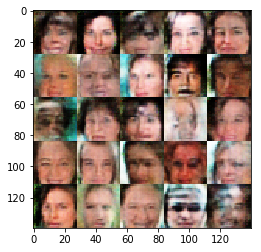

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7233


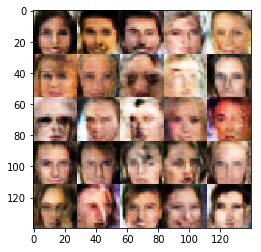

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.3285


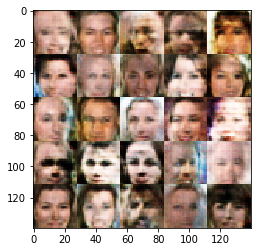

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9602


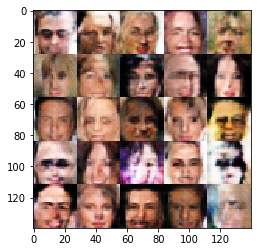

Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6919


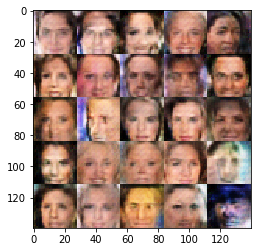

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.3355


IndexError: list index out of range

In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.